# Specs Consulting: Forecastingg Real Estate Trends in NYC, LA, CHI, MIA & DFW

 ![alternative text](images/specs_consulting.png)

# Load in Libraries & Data

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error



df = pd.read_csv('data/zillow_data.csv.zip')

In [125]:
#here we are filtering out our zipcodes to just look at the top 500 in sizerank
df['Top500'] = df['SizeRank'].apply(lambda x: True if x <= 500 else False)

df = df.loc[df.Top500, :]

#creating growth rate metric and sorting to see top zips
df['GrowthRate'] = df['2018-04'] / df['1996-04'] - 1
df.sort_values('GrowthRate', ascending = False)[:5]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Top500,GrowthRate
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,True,11.189940
475,62027,11216,New York,NY,New York,Kings,476,146100.0,146600.0,147200.0,...,1553100,1567700,1559700,1545700,1540200,1553600,1578400,1598700,True,9.942505
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300,True,9.403061
106,62026,11215,New York,NY,New York,Kings,107,225700.0,227500.0,229400.0,...,2244400,2266100,2275800,2287100,2288900,2265300,2244900,2243900,True,8.941958
258,66125,20001,Washington,DC,Washington,District of Columbia,259,92000.0,92600.0,93200.0,...,771200,773300,777600,780500,781600,785500,791400,793300,True,7.622826


In [84]:
#checking which metros have the most top500 sizerank zipcodes
#we are not using houston and atlanta as they have lower growth rates than then rest
df.value_counts('Metro')[:7]

Metro
New York                          46
Los Angeles-Long Beach-Anaheim    32
Chicago                           27
Atlanta                           23
Miami-Fort Lauderdale             20
Houston                           20
Dallas-Fort Worth                 19
dtype: int64

In [85]:
#showing that almost half of zip codes in our top 500 are represented in the top 10 metros
df.value_counts('Metro')[:10].sum()

226

In [86]:
#making dfs for our Metros and checking mean growthrate
#going to use NYC, Chi, LA, MIA, and DFW highest growth rates with atleast 20 zipcodes
df_nyc = df[df['Metro'] == 'New York']
df_chi = df[df['Metro'] == 'Chicago']
df_la = df[df['Metro'] == 'Los Angeles-Long Beach-Anaheim']
df_dfw = df[df['Metro'] == 'Dallas-Fort Worth']
df_mia = df[df['Metro'] == 'Miami-Fort Lauderdale']

In [87]:
#showing growth rate in descending order
print('NYC:')
print(df_nyc['GrowthRate'].mean())
print('LA:')
print(df_la['GrowthRate'].mean())
print('MIA:')
print(df_mia['GrowthRate'].mean())
print('CHI:')
print(df_chi['GrowthRate'].mean())
print('DFW:')
print(df_dfw['GrowthRate'].mean())

NYC:
3.7712542878046262
LA:
3.2231950761389916
MIA:
1.9554887689343101
CHI:
1.3872262487454181
DFW:
0.9493054726931407


# Convert Dataframes to Datetime

In [88]:
# function for datetimes
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    
    return pd.to_datetime(df.columns.values[7:272], format='%Y-%m')

In [89]:
get_datetimes(df_nyc)
get_datetimes(df_la)
get_datetimes(df_mia)
get_datetimes(df_dfw)
get_datetimes(df_chi)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

# Melt Data into Long-Form 

In [90]:
#funtion for melting dataframes
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName', 'Top500', 'GrowthRate'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [91]:
df_nyc = melt_data(df_nyc)
df_la = melt_data(df_la)
df_dfw = melt_data(df_dfw)
df_mia = melt_data(df_mia)
df_chi = melt_data(df_chi)

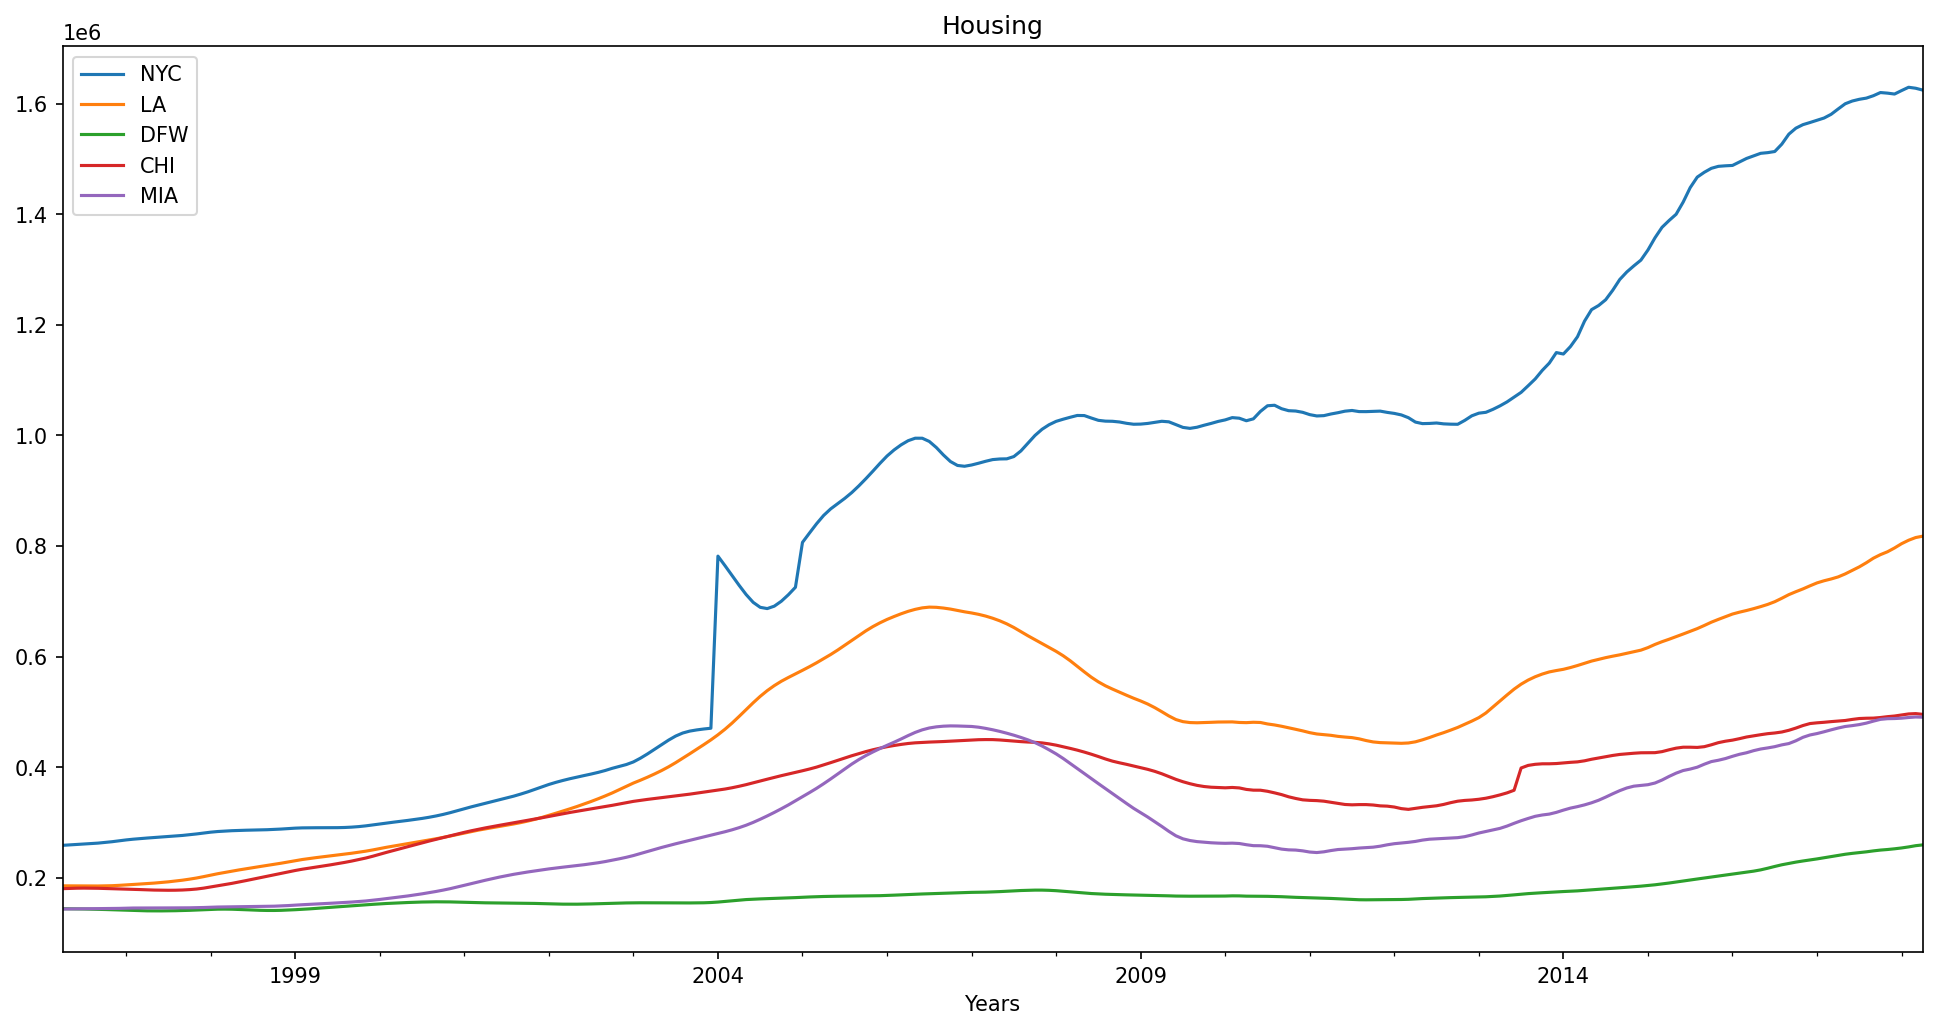

In [128]:
# Here is a plot showing all our Metros mean prices from 1996 to 2018
plt.figure(figsize=(16, 8), dpi=150)
  

df_nyc['value'].plot(label='NYC')
df_la['value'].plot(label='LA')
df_dfw['value'].plot(label='DFW')
df_chi['value'].plot(label='CHI')
df_mia['value'].plot(label='MIA')
# adding title to the plot
plt.title('Housing')
  
# adding Label to the x-axis
plt.xlabel('Years')
  
# adding legend to the curve
plt.legend();



# Modeling
Before modeling, we have to remove any trends from the data through making the data stationary. Then, we create ARIMA models to forecast our predicted directions for each market.

In [93]:
#function for checking stationarity
def stationarity_check(df):

    
    # Calculate rolling statistics
    roll_mean = df.rolling(window=8, center=False).mean()
    roll_std = df.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(df['value'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# NYC

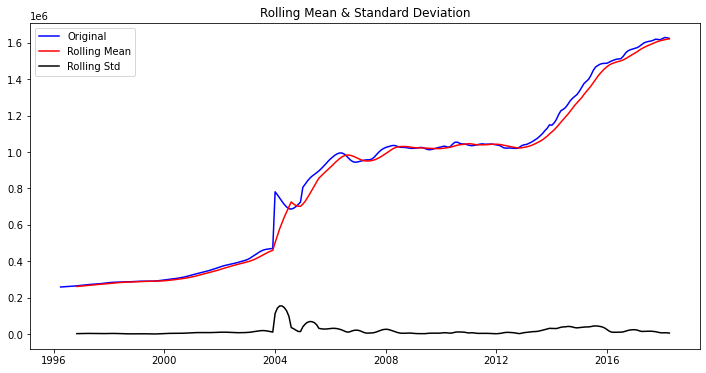

Results of Dickey-Fuller Test: 

Test Statistic                   0.531359
p-value                          0.985796
#Lags Used                       0.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


In [94]:
stationarity_check(df_nyc)

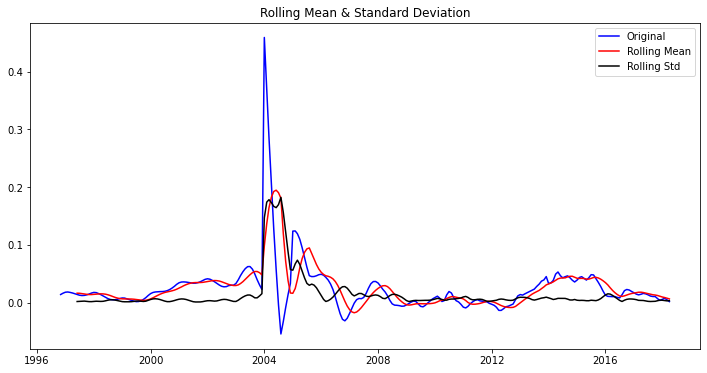

Results of Dickey-Fuller Test: 

Test Statistic                -5.811146e+00
p-value                        4.398470e-07
#Lags Used                     1.000000e+00
Number of Observations Used    2.560000e+02
Critical Value (1%)           -3.456155e+00
Critical Value (5%)           -2.872897e+00
Critical Value (10%)          -2.572822e+00
dtype: float64


In [95]:
# Subtract the moving average from the log transformed data
# lets create a log transform so we can substract the rolling mean 
roll_mean_nyc = np.log(df_nyc).rolling(window=8).mean()
data_minus_roll_mean_nyc = np.log(df_nyc) - roll_mean_nyc

data_minus_roll_mean_nyc.dropna(inplace=True)

stationarity_check(data_minus_roll_mean_nyc)
model_nyc = data_minus_roll_mean_nyc

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  246
Model:                 ARIMA(2, 0, 4)   Log Likelihood                 517.541
Date:                Thu, 27 Oct 2022   AIC                          -1019.081
Time:                        13:33:09   BIC                           -991.038
Sample:                    11-01-1996   HQIC                         -1007.790
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.043      0.584      0.559      -0.059       0.110
ar.L1          1.3990      1.190      1.176      0.240      -0.933       3.731
ar.L2         -0.4569      0.915     -0.499      0.6

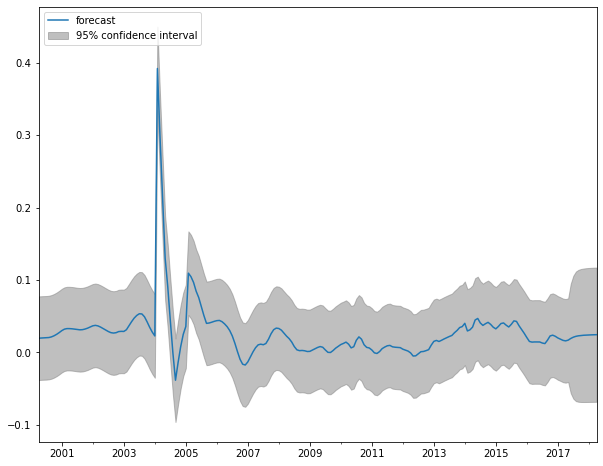

In [96]:
train = model_nyc.iloc[:-12]
test = model_nyc.iloc[-12:]

arima_nyc = ARIMA(train, order=(2,0,4))
arima_nyc_model = arima_nyc.fit()
print(arima_nyc_model.summary())


fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima_nyc_model, start="2000-04-01", end="2018-04-01", ax=ax)
legend = ax.legend(loc="upper left")

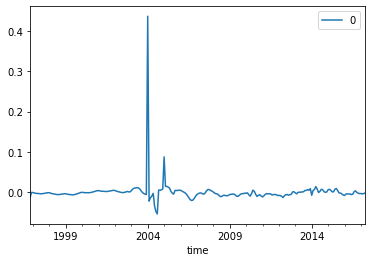

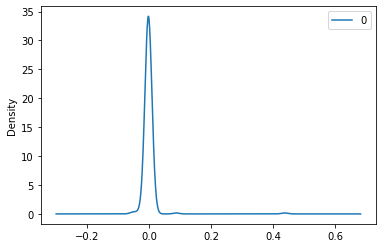

                0
count  246.000000
mean     0.000035
std      0.029525
min     -0.053588
25%     -0.005324
50%     -0.002180
75%      0.002231
max      0.436189


In [97]:
residuals = pd.DataFrame(arima_nyc_model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

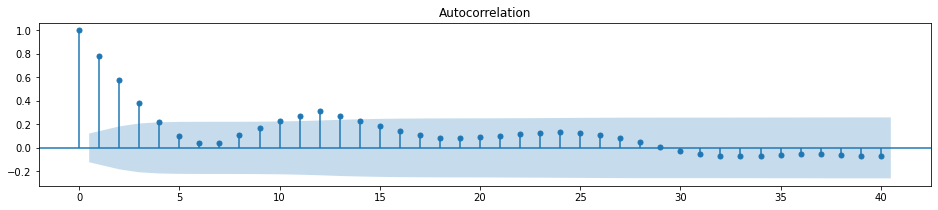

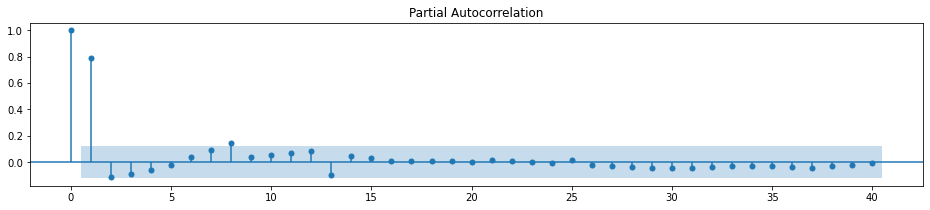

In [98]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(model_nyc, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(model_nyc, ax=ax, lags=40);

# LA

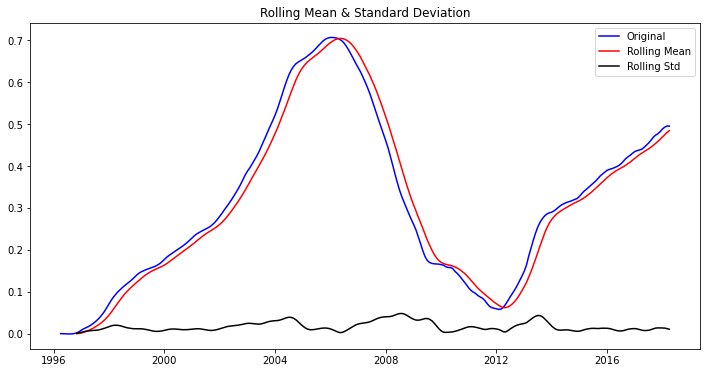

Results of Dickey-Fuller Test: 

Test Statistic                  -2.863459
p-value                          0.049765
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [99]:
#status check: success! p-value is below 0.05 
exp_roll_mean_la = np.log(df_la).ewm(alpha = .005).mean()
data_minus_exp_roll_mean_la = np.log(df_la) - exp_roll_mean_la
stationarity_check(data_minus_exp_roll_mean_la)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  253
Model:                 ARIMA(4, 0, 5)   Log Likelihood                1396.090
Date:                Thu, 27 Oct 2022   AIC                          -2770.181
Time:                        13:33:12   BIC                          -2731.314
Sample:                    04-01-1996   HQIC                         -2754.543
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3019      0.054      5.622      0.000       0.197       0.407
ar.L1          3.0095      0.149     20.238      0.000       2.718       3.301
ar.L2         -3.2853      0.416     -7.891      0.0

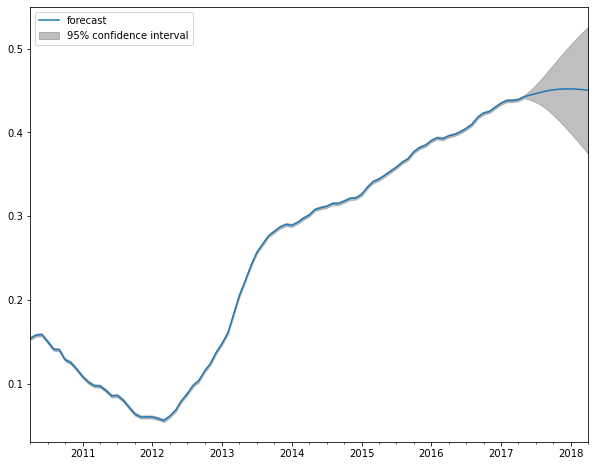

In [100]:
model_la = data_minus_exp_roll_mean_la
train = model_la.iloc[:-12]
test = model_la.iloc[-12:]

arima_la = ARIMA(train, order=(4,0,5))
arima_la = arima_la.fit()
print(arima_la.summary())

fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima_la, start="2010-04-01", end="2018-04-01", ax=ax, dynamic=False)
legend = ax.legend(loc="upper left")

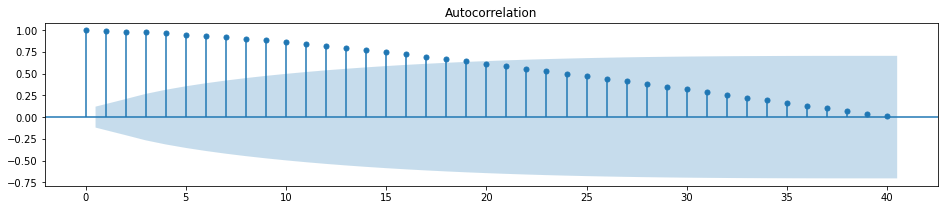

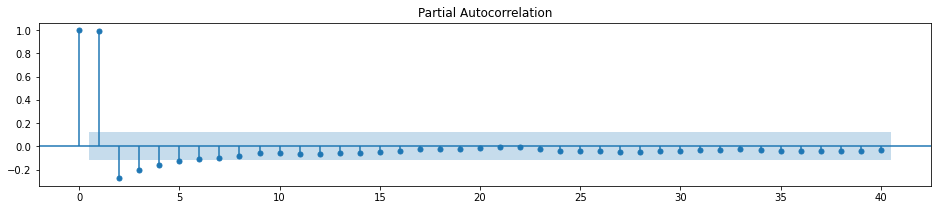

In [101]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(model_la, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(model_la, ax=ax, lags=40);

# DFW

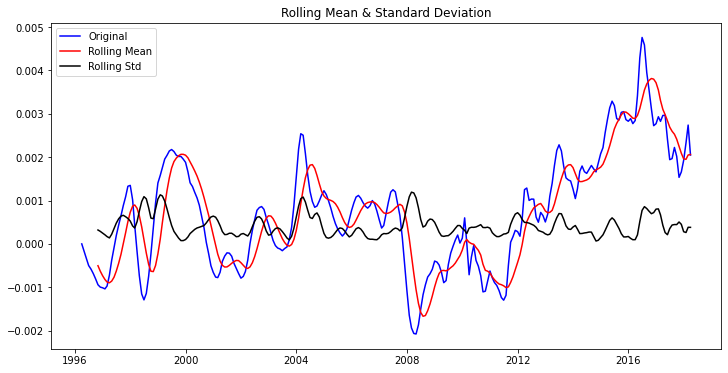

Results of Dickey-Fuller Test: 

Test Statistic                  -2.829496
p-value                          0.054182
#Lags Used                       5.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [102]:
exp_roll_mean_dfw = np.log(df_dfw).ewm(halflife = .5).mean()

data_minus_exp_roll_mean_dfw = np.log(df_dfw) - exp_roll_mean_dfw
stationarity_check(data_minus_exp_roll_mean_dfw)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  253
Model:                ARIMA(0, 0, 14)   Log Likelihood                1756.904
Date:                Thu, 27 Oct 2022   AIC                          -3481.809
Time:                        13:33:18   BIC                          -3425.275
Sample:                    04-01-1996   HQIC                         -3459.063
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -0.685      0.493      -0.001       0.001
ma.L1          1.5634      0.039     40.485      0.000       1.488       1.639
ma.L2          2.3092      0.037     62.003      0.0

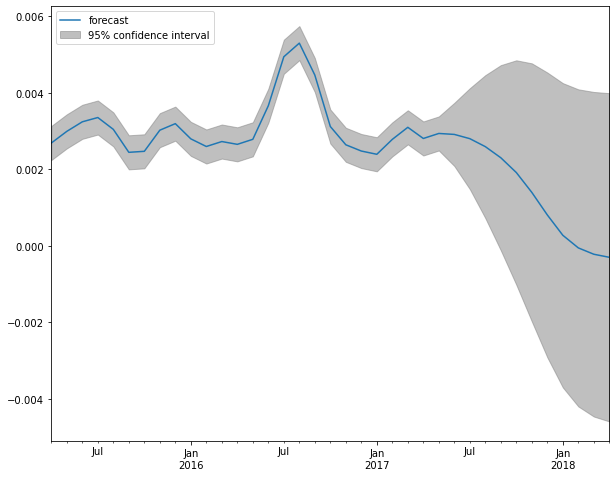

In [103]:
model_dfw = data_minus_exp_roll_mean_dfw
train = model_dfw.iloc[:-12]
test = model_dfw.iloc[-12:]

arima_dfw = ARIMA(train, order=(0,0,14))
arima_dfw = arima_dfw.fit()
print(arima_dfw.summary())


fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima_dfw, start="2015-04-01", end="2018-04-01", ax=ax)
legend = ax.legend(loc="upper left")

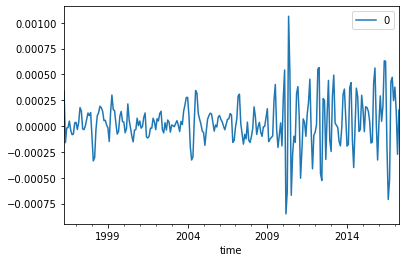

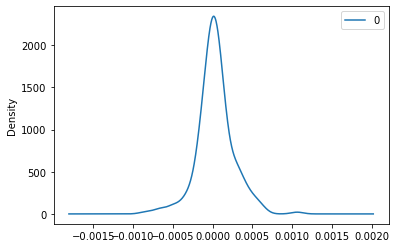

                0
count  253.000000
mean     0.000034
std      0.000229
min     -0.000850
25%     -0.000077
50%      0.000028
75%      0.000131
max      0.001063


In [104]:
residuals = pd.DataFrame(arima_dfw.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

<AxesSubplot:xlabel='time'>

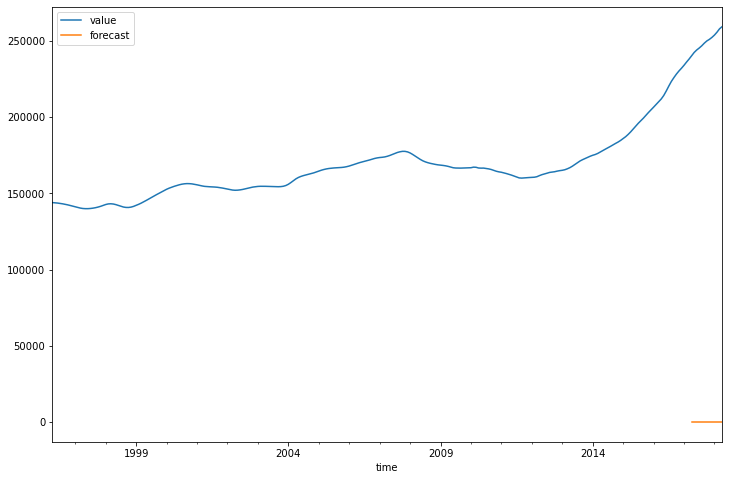

In [105]:
df_dfw['forecast']=arima_dfw.predict(start='2017-04-01',end='2018-04-01',dynamic=True)
df_dfw[['value','forecast']].plot(figsize=(12,8))

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


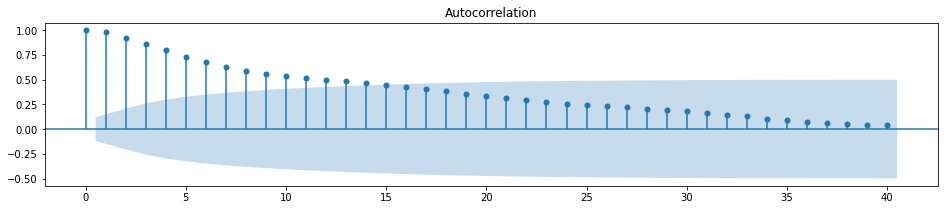

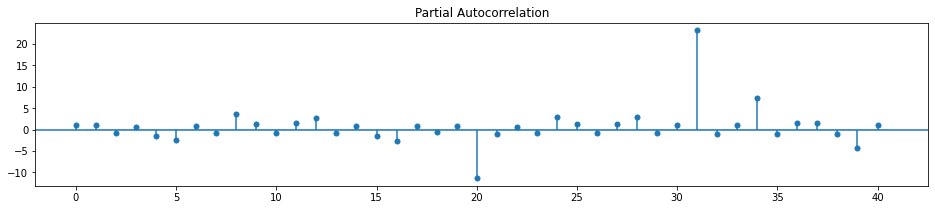

In [106]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(model_dfw, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(model_dfw, ax=ax, lags=40);

# CHI

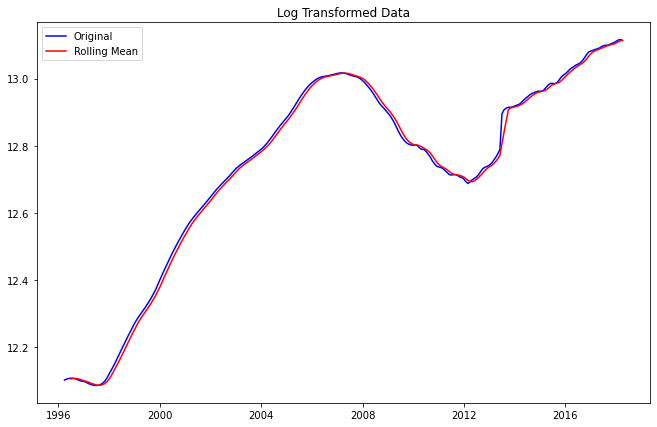

In [107]:
roll_mean_chi = np.log(df_chi).rolling(window=4).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(np.log(df_chi), color='blue', label='Original')
plt.plot(roll_mean_chi, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

In [108]:
data_minus_roll_mean_chi = np.log(df_chi) - roll_mean_chi

# Print the first 10 rows
data_minus_roll_mean_chi.head(10)
data_minus_roll_mean_chi.dropna(inplace=True)

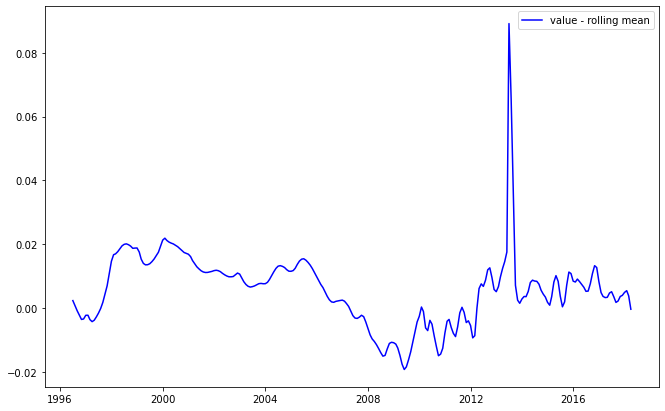

In [109]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean_chi, color='blue',label='value - rolling mean')
plt.legend(loc='best')
plt.show(block=False)

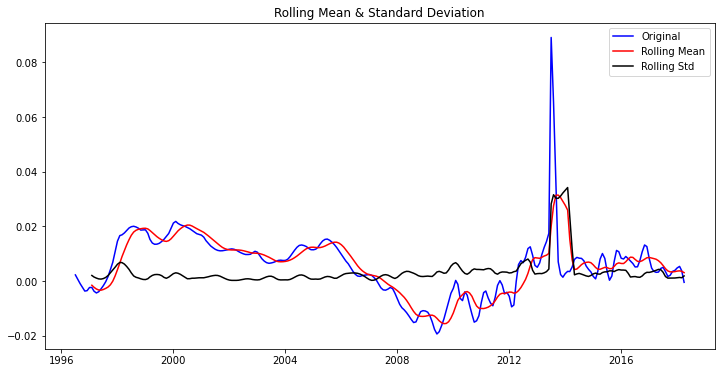

Results of Dickey-Fuller Test: 

Test Statistic                  -3.281159
p-value                          0.015742
#Lags Used                       3.000000
Number of Observations Used    258.000000
Critical Value (1%)             -3.455953
Critical Value (5%)             -2.872809
Critical Value (10%)            -2.572775
dtype: float64


In [110]:
stationarity_check(data_minus_roll_mean_chi)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  250
Model:                ARIMA(1, 0, 13)   Log Likelihood                 953.684
Date:                Thu, 27 Oct 2022   AIC                          -1875.367
Time:                        13:33:25   BIC                          -1819.024
Sample:                    07-01-1996   HQIC                         -1852.691
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.010      0.559      0.576      -0.014       0.025
ar.L1          0.9225      0.150      6.154      0.000       0.629       1.216
ma.L1          0.0650      0.153      0.425      0.6

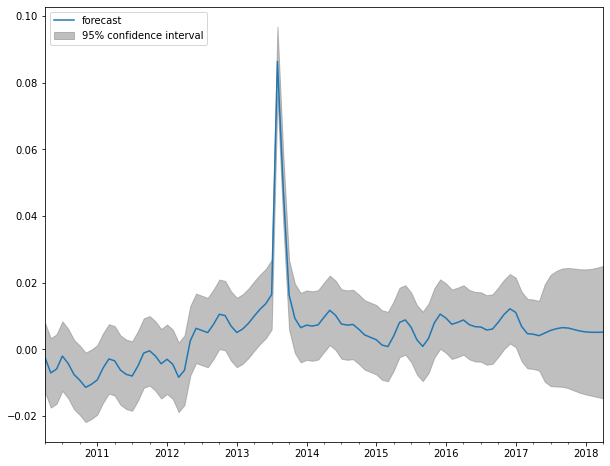

In [111]:
model_chi = data_minus_roll_mean_chi
train = model_chi.iloc[:-12]
test = model_chi.iloc[-12:]

arima_chi = ARIMA(train, order=(1,0,13))
arima_chi = arima_chi.fit()
print(arima_chi.summary())


fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima_chi, start="2010-04-01", end="2018-04-01", ax=ax)
legend = ax.legend(loc="upper left")

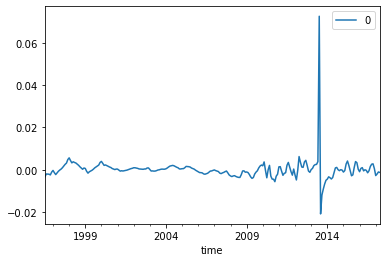

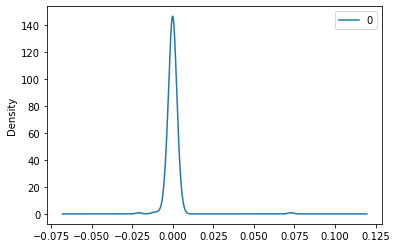

                0
count  250.000000
mean     0.000029
std      0.005329
min     -0.020990
25%     -0.001406
50%     -0.000047
75%      0.001211
max      0.072765


In [112]:
residuals = pd.DataFrame(arima_chi.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

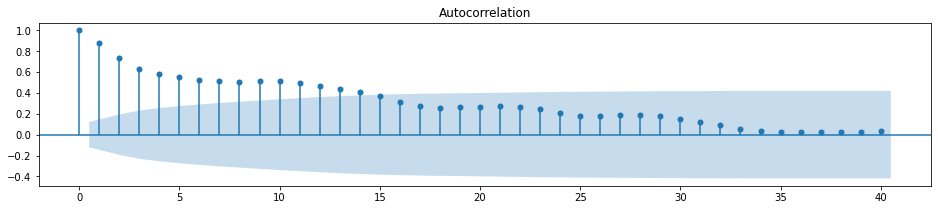

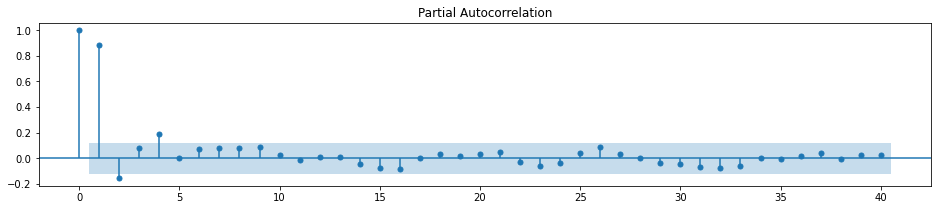

In [113]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(model_chi, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(model_chi, ax=ax, lags=40);

# MIA

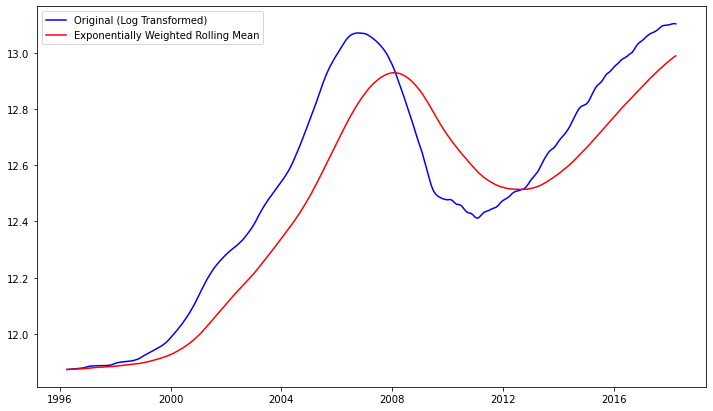

In [114]:
exp_roll_mean_mia = np.log(df_mia).ewm(alpha=0.05).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(df_mia), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean_mia, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

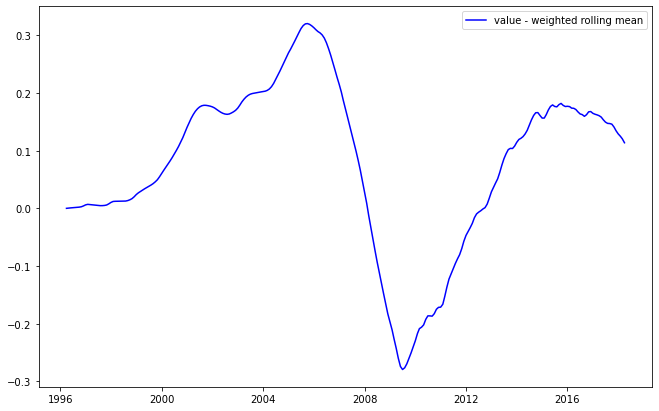

In [115]:
data_minus_exp_roll_mean_mia = np.log(df_mia) - exp_roll_mean_mia

# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean_mia, color='blue',label='value - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

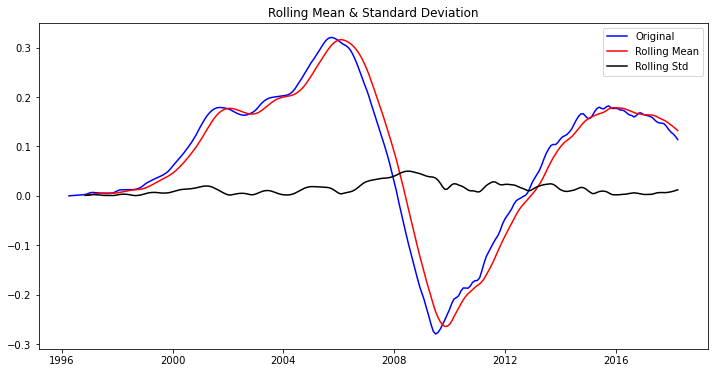

Results of Dickey-Fuller Test: 

Test Statistic                  -3.062570
p-value                          0.029450
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [116]:
stationarity_check(data_minus_exp_roll_mean_mia)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/learn-env/lib/python3.8

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  253
Model:                ARIMA(0, 0, 18)   Log Likelihood                1214.639
Date:                Thu, 27 Oct 2022   AIC                          -2389.279
Time:                        13:33:39   BIC                          -2318.611
Sample:                    04-01-1996   HQIC                         -2360.847
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0374      0.023      1.625      0.104      -0.008       0.082
ma.L1          3.1099      0.073     42.861      0.000       2.968       3.252
ma.L2          5.4712      0.229     23.936      0.0

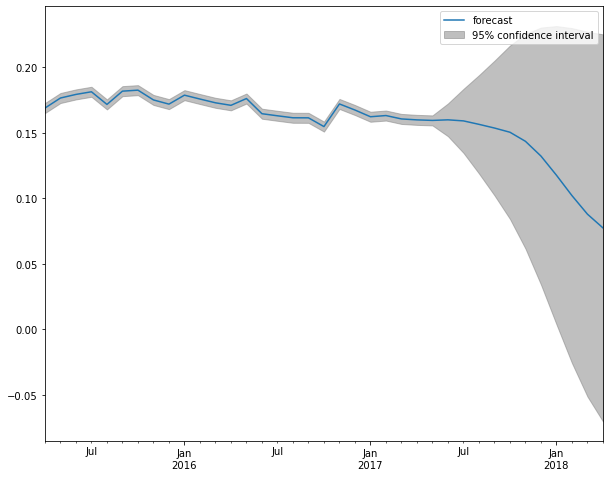

In [117]:
model_mia = data_minus_exp_roll_mean_mia
train = model_mia.iloc[:-12]
test = model_mia.iloc[-12:]

arima_mia = ARIMA(train, order=(0,0,18))
arima_res = arima_mia.fit()
print(arima_res.summary())


fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima_res, start="2015-04-01", end="2018-04-01", ax=ax)
plt.show()
legend = ax.legend(loc="upper left")

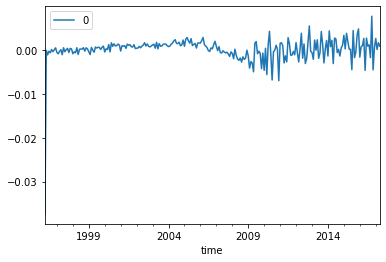

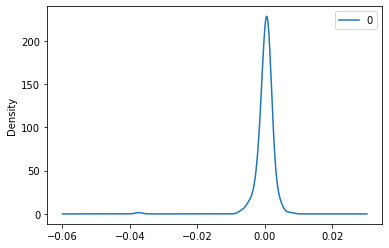

                0
count  253.000000
mean     0.000122
std      0.003029
min     -0.037375
25%     -0.000573
50%      0.000446
75%      0.001287
max      0.007691


In [118]:
residuals = pd.DataFrame(arima_res.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


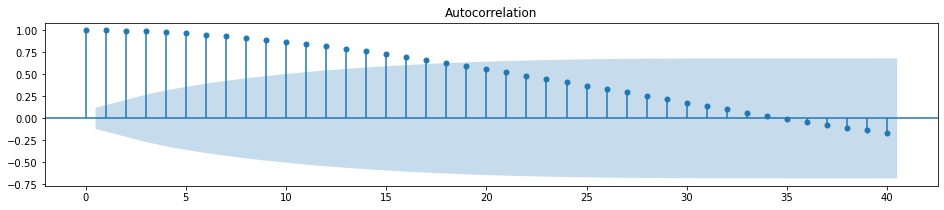

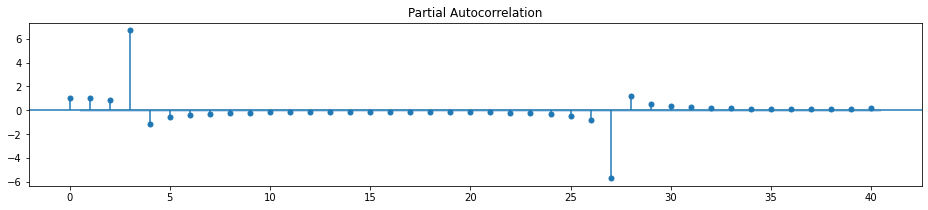

In [119]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(model_mia, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(model_mia, ax=ax, lags=40);